Task 0 processed with response time 151.61866666666666
No VMs available in data center Provider_1_Region_2
Task 2 processed with response time 150.5653333333333
Task 3 processed with response time 152.02666666666664
Task 4 processed with response time 51.20666666666665
Task 5 processed with response time 151.15733333333338
Task 6 processed with response time 10.34041666666667
Task 7 processed with response time 51.438333333333276
Task 8 processed with response time 152.39999999999998
Task 9 processed with response time 151.33066666666662
Task 10 processed with response time 10.683999999999969
Task 11 processed with response time 152.38666666666654
Task 12 processed with response time 51.38333333333344
Task 13 processed with response time 50.441666666666606
Task 14 processed with response time 51.11999999999989
Task 15 processed with response time 10.436999999999898
Task 16 processed with response time 10.2501666666667
No VMs available in data center Provider_1_Region_0
Task 18 processe

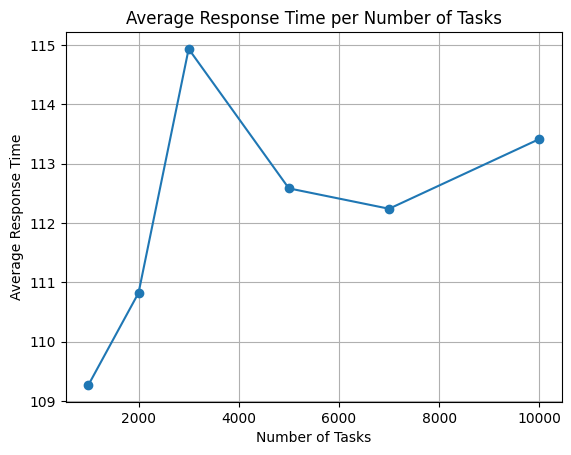

In [1]:
import simpy
import random
from sklearn.cluster import SpectralClustering
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Define the fuzzy variables and rules
def define_fis():
    transfer_time_ratio = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'transfer_time_ratio')
    load = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'load')
    availability = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'availability')
    profit = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'profit')
    placement_potential = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'placement_potential')

    # Define fuzzy sets
    transfer_time_ratio.automf(3, names=['Low', 'Medium', 'High'])
    load.automf(3, names=['Low', 'Medium', 'High'])
    availability['NR'] = fuzz.trimf(availability.universe, [0, 0, 0.5])
    availability['R'] = fuzz.trimf(availability.universe, [0.5, 1, 1])
    profit['NP'] = fuzz.trimf(profit.universe, [0, 0, 0.5])
    profit['P'] = fuzz.trimf(profit.universe, [0.5, 1, 1])

    placement_potential['Very Low'] = fuzz.trimf(placement_potential.universe, [0, 0, 0.25])
    placement_potential['Low'] = fuzz.trimf(placement_potential.universe, [0, 0.25, 0.5])
    placement_potential['Medium'] = fuzz.trimf(placement_potential.universe, [0.25, 0.5, 0.75])
    placement_potential['High'] = fuzz.trimf(placement_potential.universe, [0.5, 0.75, 1])
    placement_potential['Very High'] = fuzz.trimf(placement_potential.universe, [0.75, 1, 1])

    # Define fuzzy rules
    rules = [
        ctrl.Rule(transfer_time_ratio['High'] & load['High'] & availability['NR'] & profit['NP'], placement_potential['Very Low']),
        ctrl.Rule(transfer_time_ratio['High'] & load['Medium'] & availability['NR'] & profit['NP'], placement_potential['Low']),
        ctrl.Rule(transfer_time_ratio['Medium'] & load['Medium'] & availability['NR'] & profit['NP'], placement_potential['Medium']),
        ctrl.Rule(transfer_time_ratio['Medium'] & load['Medium'] & availability['R'] & profit['P'], placement_potential['High']),
        ctrl.Rule(transfer_time_ratio['Low'] & load['Low'] & availability['R'] & profit['P'], placement_potential['Very High']),
    ]

    # Create control system and simulation
    placement_ctrl = ctrl.ControlSystem(rules)
    placement_sim = ctrl.ControlSystemSimulation(placement_ctrl)

    return placement_sim

placement_sim = define_fis()

class VirtualMachine:
    def __init__(self, env, id, processing_capability, num_cpus, ram, storage_capacity, data_center, region, bw_params):
        self.env = env
        self.id = id
        self.processing_capability = processing_capability
        self.num_cpus = num_cpus
        self.ram = ram
        self.storage_capacity = storage_capacity
        self.data_center = data_center
        self.region = region
        self.bw_params = bw_params
        self.uptime = 0
        self.total_time = 0
        self.data_access_log = {}
        self.tasks_processed = 0
        self.load = 0  # Track the load of VM
        self.total_transfer_time = 0  # Track total transfer time for calculating metrics
    
    def update_availability(self, time_passed):
        self.total_time += time_passed
    
    def get_availability(self):
        if self.total_time == 0:
            return 1
        return self.uptime / self.total_time
    
    def calculate_data_transfer_time(self, size, target_dc):
        if self.data_center == target_dc:
            bw = self.bw_params['intra_dc']
        elif self.region == target_dc.region:
            bw = self.bw_params['intra_region']
        else:
            bw = self.bw_params['inter_region']
        transfer_time = size / bw['capacity'] + bw['delay']
        return transfer_time
    
    def process_task(self, task, target_dc):
        data_transfer_time = self.calculate_data_transfer_time(task['size'], target_dc)
        start_time = self.env.now
        total_processing_time = task['size'] / self.processing_capability + data_transfer_time
        yield self.env.timeout(total_processing_time)
        end_time = self.env.now

        self.tasks_processed += 1
        self.load = self.tasks_processed / self.total_time if self.total_time > 0 else 0
        self.total_transfer_time += data_transfer_time
        
        response_time = end_time - start_time
        sla_rt = 60  # SLORT in seconds
        sla_ma = 0.95  # SLOMA in seconds
        w = 0.8  # Define the weight factor
        th_rt = w * sla_rt

        penalty = 0
        near_violation = False
        if response_time > sla_rt:
            penalty = 0.0025
        elif response_time > th_rt:
            near_violation = True

        cost = self.data_center.calculate_cost(task['size'], target_dc) - penalty
        self.data_center.total_revenue += cost

        if near_violation:
            self.data_access_log[task['id']] = (task, response_time, data_transfer_time)

class DataCenter:
    def __init__(self, env, id, region, pricing):
        self.env = env
        self.id = id
        self.region = region
        self.pricing = pricing
        self.total_revenue = 0
        self.vms = []
    
    def add_vm(self, vm):
        self.vms.append(vm)
    
    def calculate_cost(self, size, target_dc):
        cpu_price = self.pricing.get('cpu_price', 0)
        bw_price = self.pricing['bw_price']
        if self == target_dc:
            bw_cost = bw_price['intra_dc']
        elif self.region == target_dc.region:
            bw_cost = bw_price['intra_region']
        else:
            bw_cost = bw_price['inter_region']
        return size * cpu_price + bw_cost * size

class CloudProvider:
    def __init__(self, env, id, num_regions, dcs_per_provider, num_vms_per_dc, vm_specs, pricing, bw_params):
        self.env = env
        self.id = id
        self.regions = []
        self.pricing = pricing
        self.bw_params = bw_params
        self.owned_vms = []
        self.offered_vms = []
        self.rented_vms = []
        for i in range(num_regions):
            region_id = f'{id}_Region_{i}'
            region = DataCenter(env, region_id, i, pricing)
            self.regions.append(region)
            num_dcs = random.randint(*dcs_per_provider)
            for j in range(num_dcs):
                dc_id = f'{region_id}_DC_{j}'
                data_center = DataCenter(env, dc_id, i, pricing)
                self.add_data_center_vms(data_center, num_vms_per_dc)
                self.owned_vms.extend(data_center.vms)
                self.regions.append(data_center)

    def add_data_center_vms(self, data_center, num_vms_per_dc):
        for _ in range(num_vms_per_dc):
            vm_id = f'{data_center.id}_VM_{len(data_center.vms)}'
            vm = VirtualMachine(
                self.env, vm_id, vm_specs['processing_capability'], vm_specs['num_cpus'],
                vm_specs['ram'], vm_specs['storage_capacity'], data_center, data_center.region, bw_params)
            data_center.add_vm(vm)

    def get_total_revenue(self):
        return sum(dc.total_revenue for dc in self.regions)
    
    def offer_idle_vms(self):
        self.offered_vms = [vm for vm in self.owned_vms if vm.load < 0.5 and vm not in self.offered_vms]
    
    def rent_vms(self, other_provider):
        for vm in other_provider.offered_vms:
            if vm not in self.rented_vms:
                self.rented_vms.append(vm)
                if vm in other_provider.owned_vms:
                    other_provider.owned_vms.remove(vm)
                if vm in other_provider.offered_vms:
                    other_provider.offered_vms.remove(vm)

def spectral_clustering(data_access_log, n_clusters):
    if len(data_access_log) == 0:
        return []
    
    task_ids = list(data_access_log.keys())
    data = np.array([[log[1], log[2]] for log in data_access_log.values()])
    
    clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=0).fit(data)
    clusters = {i: [] for i in range(n_clusters)}
    for idx, label in enumerate(clustering.labels_):
        clusters[label].append(task_ids[idx])
    return clusters

def place_replicas(clusters, providers, placement_sim):
    for cluster_id, tasks in clusters.items():
        for task_id in tasks:
            task = next((t for p in providers for dc in p.regions for vm in dc.vms for t in vm.data_access_log.values() if t[0]['id'] == task_id), None)
            if task:
                max_potential = 0
                best_vm = None
                for provider in providers:
                    for dc in provider.regions:
                        for vm in dc.vms:
                            transfer_time_ratio = calculate_transfer_time_ratio(vm)
                            load = calculate_load(vm)
                            availability = calculate_data_availability(vm)
                            profit = calculate_profit(provider)

                            placement_sim.input['transfer_time_ratio'] = transfer_time_ratio
                            placement_sim.input['load'] = load
                            placement_sim.input['availability'] = availability
                            placement_sim.input['profit'] = profit

                            placement_sim.compute()
                            potential = placement_sim.output['placement_potential']

                            if potential > max_potential:
                                max_potential = potential
                                best_vm = vm

                if best_vm:
                    best_vm.data_access_log[task_id] = task

def run_simulation(env, providers, tasks, P, K):
    task_count = 0
    response_times = []
    for task in tasks:
        task_count += 1
        provider = random.choice(providers)
        if not provider.regions:
            print(f"No regions available for provider {provider.id}")
            continue
        dc = random.choice(provider.regions)
        if not dc.vms:
            print(f"No VMs available in data center {dc.id}")
            continue
        vm = random.choice(dc.vms)
        target_dc = random.choice(provider.regions)

        if not vm or not target_dc:
            print(f"No VM or target data center available for task {task['id']}")
            continue

        start_time = env.now
        env.process(vm.process_task(task, target_dc))
        env.run()
        response_time = env.now - start_time
        response_times.append(response_time)
        print(f"Task {task['id']} processed with response time {response_time}")

        if task_count >= P:
            for provider in providers:
                provider.offer_idle_vms()
                for other_provider in providers:
                    if other_provider != provider:
                        provider.rent_vms(other_provider)
            
            for dc in provider.regions:
                for vm in dc.vms:
                    if len(vm.data_access_log) >= P:
                        clusters = spectral_clustering(vm.data_access_log, K)
                        place_replicas(clusters, providers, placement_sim)
                        vm.data_access_log.clear()

    average_response_time = np.mean(response_times) if response_times else float('inf')
    return average_response_time

# Metrics Calculation
def calculate_transfer_time_ratio(vm):
    if not vm.data_access_log:
        return 0
    DTT = vm.total_transfer_time / len(vm.data_access_log)
    LDTT = min(vm.bw_params['intra_dc']['capacity'], vm.bw_params['intra_region']['capacity'], vm.bw_params['inter_region']['capacity']) / max(vm.bw_params['intra_dc']['delay'], vm.bw_params['intra_region']['delay'], vm.bw_params['inter_region']['delay'])
    return DTT / LDTT if LDTT != 0 else 0

def calculate_load(vm):
    return vm.load

def calculate_data_availability(vm):
    return vm.get_availability()

def calculate_profit(provider):
    total_revenue = provider.get_total_revenue()
    total_cost = 0
    for dc in provider.regions:
        for vm in dc.vms:
            cost = vm.tasks_processed * provider.pricing['cpu_price'] + vm.tasks_processed * provider.pricing['storage_price']
            if vm.data_center == dc:
                bw_cost = provider.pricing['bw_price']['intra_dc'] * vm.tasks_processed
            elif vm.region == dc.region:
                bw_cost = provider.pricing['bw_price']['intra_region'] * vm.tasks_processed
            else:
                bw_cost = provider.pricing['bw_price']['inter_region'] * vm.tasks_processed
            total_cost += cost + bw_cost
    profit = total_revenue - total_cost
    return profit

# Simulation parameters
num_providers = 3
num_regions = 3
dcs_per_provider = (2, 5)
num_vms_per_dc = 8
vm_specs = {
    'processing_capability': 1500,  # in MIPS
    'num_cpus': 2,
    'ram': 4,  # in Gb
    'storage_capacity': 8  # in Gb
}

# Bandwidth parameters
bw_params = {
    'inter_region': {'capacity': 500, 'delay': 150},
    'intra_region': {'capacity': 1000, 'delay': 50},
    'intra_dc': {'capacity': 8000, 'delay': 10}
}

pricing = {
    'Provider_1': {
        'cpu_price': 0.01,
        'storage_price': 0.001,
        'bw_price': {'intra_dc': 0.001, 'intra_region': 0.002, 'inter_region': 0.01}
    },
    'Provider_2': {
        'cpu_price': 0.0095,
        'storage_price': 0.0012,
        'bw_price': {'intra_dc': 0.001, 'intra_region': 0.002, 'inter_region': 0.008}
    },
    'Provider_3': {
        'cpu_price': 0.009,
        'storage_price': 0.0096,
        'bw_price': {'intra_dc': 0.0015, 'intra_region': 0.002, 'inter_region': 0.008}
    }
}

task_counts = [1000, 2000, 3000, 5000, 7000, 10000]
average_response_times = []

for num_tasks in task_counts:
    # Initialize the environment and providers
    env = simpy.Environment()
    providers = []
    for i in range(num_providers):
        provider_key = f'Provider_{i+1}'
        if provider_key in pricing:
            provider = CloudProvider(env, provider_key, num_regions, dcs_per_provider, num_vms_per_dc, vm_specs, pricing[provider_key], bw_params)
            providers.append(provider)
        else:
            print(f"Warning: Pricing not found for {provider_key}")

    tasks = [{'id': i, 'size': random.randint(200, 1000)} for i in range(num_tasks)]
    average_response_time = run_simulation(env, providers, tasks, 32, 3)
    average_response_times.append(average_response_time)
    print(f"Number of Tasks: {num_tasks}, Average Response Time: {average_response_time}")

plt.plot(task_counts, average_response_times, marker='o')
plt.xlabel('Number of Tasks')
plt.ylabel('Average Response Time')
plt.title('Average Response Time per Number of Tasks')
plt.grid(True)
plt.show()


Task 0 processed with response time 51.01833333333333 ms
No VMs available in data center Provider_3_Region_1
Task 2 processed with response time 51.266666666666666 ms
Task 3 processed with response time 151.936 ms
Task 4 processed with response time 152.38133333333337 ms
No VMs available in data center Provider_3_Region_0
Task 6 processed with response time 151.70399999999995 ms
Task 7 processed with response time 151.11199999999997 ms
Task 8 processed with response time 151.42666666666662 ms
Task 9 processed with response time 151.7893333333334 ms
Task 10 processed with response time 150.72266666666667 ms
No VMs available in data center Provider_2_Region_0
Task 12 processed with response time 151.55733333333342 ms
Task 13 processed with response time 50.831666666666706 ms
Task 14 processed with response time 151.97333333333336 ms
Task 15 processed with response time 152.34666666666658 ms
No VMs available in data center Provider_2_Region_1
Task 17 processed with response time 51.164999

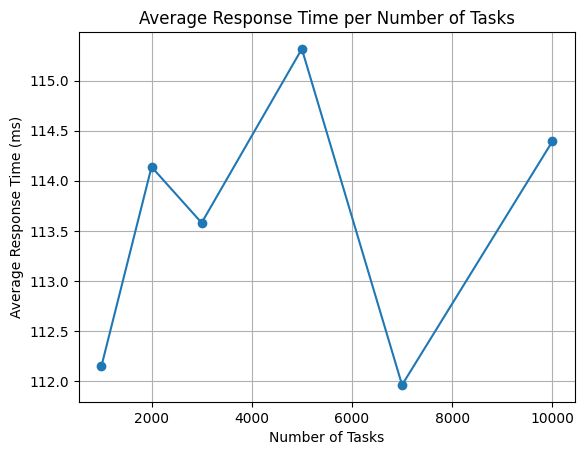

In [2]:
import simpy
import random
from sklearn.cluster import SpectralClustering
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Define the fuzzy variables and rules
def define_fis():
    transfer_time_ratio = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'transfer_time_ratio')
    load = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'load')
    availability = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'availability')
    profit = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'profit')
    placement_potential = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'placement_potential')

    # Define fuzzy sets
    transfer_time_ratio.automf(3, names=['Low', 'Medium', 'High'])
    load.automf(3, names=['Low', 'Medium', 'High'])
    availability['NR'] = fuzz.trimf(availability.universe, [0, 0, 0.5])
    availability['R'] = fuzz.trimf(availability.universe, [0.5, 1, 1])
    profit['NP'] = fuzz.trimf(profit.universe, [0, 0, 0.5])
    profit['P'] = fuzz.trimf(profit.universe, [0.5, 1, 1])

    placement_potential['Very Low'] = fuzz.trimf(placement_potential.universe, [0, 0, 0.25])
    placement_potential['Low'] = fuzz.trimf(placement_potential.universe, [0, 0.25, 0.5])
    placement_potential['Medium'] = fuzz.trimf(placement_potential.universe, [0.25, 0.5, 0.75])
    placement_potential['High'] = fuzz.trimf(placement_potential.universe, [0.5, 0.75, 1])
    placement_potential['Very High'] = fuzz.trimf(placement_potential.universe, [0.75, 1, 1])

    # Define fuzzy rules
    rules = [
        ctrl.Rule(transfer_time_ratio['High'] & load['High'] & availability['NR'] & profit['NP'], placement_potential['Very Low']),
        ctrl.Rule(transfer_time_ratio['High'] & load['Medium'] & availability['NR'] & profit['NP'], placement_potential['Low']),
        ctrl.Rule(transfer_time_ratio['Medium'] & load['Medium'] & availability['NR'] & profit['NP'], placement_potential['Medium']),
        ctrl.Rule(transfer_time_ratio['Medium'] & load['Medium'] & availability['R'] & profit['P'], placement_potential['High']),
        ctrl.Rule(transfer_time_ratio['Low'] & load['Low'] & availability['R'] & profit['P'], placement_potential['Very High']),
    ]

    # Create control system and simulation
    placement_ctrl = ctrl.ControlSystem(rules)
    placement_sim = ctrl.ControlSystemSimulation(placement_ctrl)

    return placement_sim

placement_sim = define_fis()

class VirtualMachine:
    def __init__(self, env, id, processing_capability, num_cpus, ram, storage_capacity, data_center, region, bw_params):
        self.env = env
        self.id = id
        self.processing_capability = processing_capability
        self.num_cpus = num_cpus
        self.ram = ram
        self.storage_capacity = storage_capacity
        self.data_center = data_center
        self.region = region
        self.bw_params = bw_params
        self.uptime = 0
        self.total_time = 0
        self.data_access_log = {}
        self.tasks_processed = 0
        self.load = 0  # Track the load of VM
        self.total_transfer_time = 0  # Track total transfer time for calculating metrics
    
    def update_availability(self, time_passed):
        self.total_time += time_passed
    
    def get_availability(self):
        if self.total_time == 0:
            return 1
        return self.uptime / self.total_time
    
    def calculate_data_transfer_time(self, size, target_dc):
        if self.data_center == target_dc:
            bw = self.bw_params['intra_dc']
        elif self.region == target_dc.region:
            bw = self.bw_params['intra_region']
        else:
            bw = self.bw_params['inter_region']
        transfer_time = size / bw['capacity'] + bw['delay']
        return transfer_time
    
    def process_task(self, task, target_dc):
        data_transfer_time = self.calculate_data_transfer_time(task['size'], target_dc)
        start_time = self.env.now
        total_processing_time = task['size'] / self.processing_capability + data_transfer_time
        yield self.env.timeout(total_processing_time)
        end_time = self.env.now

        self.tasks_processed += 1
        self.load = self.tasks_processed / self.total_time if self.total_time > 0 else 0
        self.total_transfer_time += data_transfer_time
        
        response_time = (end_time - start_time) * 1000  # Convert to milliseconds
        sla_rt = 60000  # SLORT in milliseconds
        sla_ma = 0.95  # SLOMA in seconds
        w = 0.8  # Define the weight factor
        th_rt = w * sla_rt

        penalty = 0
        near_violation = False
        if response_time > sla_rt:
            penalty = 0.0025
        elif response_time > th_rt:
            near_violation = True

        cost = self.data_center.calculate_cost(task['size'], target_dc) - penalty
        self.data_center.total_revenue += cost

        if near_violation:
            self.data_access_log[task['id']] = (task, response_time, data_transfer_time)

class DataCenter:
    def __init__(self, env, id, region, pricing):
        self.env = env
        self.id = id
        self.region = region
        self.pricing = pricing
        self.total_revenue = 0
        self.vms = []
    
    def add_vm(self, vm):
        self.vms.append(vm)
    
    def calculate_cost(self, size, target_dc):
        cpu_price = self.pricing.get('cpu_price', 0)
        bw_price = self.pricing['bw_price']
        if self == target_dc:
            bw_cost = bw_price['intra_dc']
        elif self.region == target_dc.region:
            bw_cost = bw_price['intra_region']
        else:
            bw_cost = bw_price['inter_region']
        return size * cpu_price + bw_cost * size

class CloudProvider:
    def __init__(self, env, id, num_regions, dcs_per_provider, num_vms_per_dc, vm_specs, pricing, bw_params):
        self.env = env
        self.id = id
        self.regions = []
        self.pricing = pricing
        self.bw_params = bw_params
        self.owned_vms = []
        self.offered_vms = []
        self.rented_vms = []
        for i in range(num_regions):
            region_id = f'{id}_Region_{i}'
            region = DataCenter(env, region_id, i, pricing)
            self.regions.append(region)
            num_dcs = random.randint(*dcs_per_provider)
            for j in range(num_dcs):
                dc_id = f'{region_id}_DC_{j}'
                data_center = DataCenter(env, dc_id, i, pricing)
                self.add_data_center_vms(data_center, num_vms_per_dc)
                self.owned_vms.extend(data_center.vms)
                self.regions.append(data_center)

    def add_data_center_vms(self, data_center, num_vms_per_dc):
        for _ in range(num_vms_per_dc):
            vm_id = f'{data_center.id}_VM_{len(data_center.vms)}'
            vm = VirtualMachine(
                self.env, vm_id, vm_specs['processing_capability'], vm_specs['num_cpus'],
                vm_specs['ram'], vm_specs['storage_capacity'], data_center, data_center.region, bw_params)
            data_center.add_vm(vm)

    def get_total_revenue(self):
        return sum(dc.total_revenue for dc in self.regions)
    
    def offer_idle_vms(self):
        self.offered_vms = [vm for vm in self.owned_vms if vm.load < 0.5 and vm not in self.offered_vms]
    
    def rent_vms(self, other_provider):
        for vm in other_provider.offered_vms:
            if vm not in self.rented_vms:
                self.rented_vms.append(vm)
                if vm in other_provider.owned_vms:
                    other_provider.owned_vms.remove(vm)
                if vm in other_provider.offered_vms:
                    other_provider.offered_vms.remove(vm)

def spectral_clustering(data_access_log, n_clusters):
    if len(data_access_log) == 0:
        return []
    
    task_ids = list(data_access_log.keys())
    data = np.array([[log[1], log[2]] for log in data_access_log.values()])
    
    clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=0).fit(data)
    clusters = {i: [] for i in range(n_clusters)}
    for idx, label in enumerate(clustering.labels_):
        clusters[label].append(task_ids[idx])
    return clusters

def place_replicas(clusters, providers, placement_sim):
    for cluster_id, tasks in clusters.items():
        for task_id in tasks:
            task = next((t for p in providers for dc in p.regions for vm in dc.vms for t in vm.data_access_log.values() if t[0]['id'] == task_id), None)
            if task:
                max_potential = 0
                best_vm = None
                for provider in providers:
                    for dc in provider.regions:
                        for vm in dc.vms:
                            transfer_time_ratio = calculate_transfer_time_ratio(vm)
                            load = calculate_load(vm)
                            availability = calculate_data_availability(vm)
                            profit = calculate_profit(provider)

                            placement_sim.input['transfer_time_ratio'] = transfer_time_ratio
                            placement_sim.input['load'] = load
                            placement_sim.input['availability'] = availability
                            placement_sim.input['profit'] = profit

                            placement_sim.compute()
                            potential = placement_sim.output['placement_potential']

                            if potential > max_potential:
                                max_potential = potential
                                best_vm = vm

                if best_vm:
                    best_vm.data_access_log[task_id] = task

def run_simulation(env, providers, tasks, P, K):
    task_count = 0
    response_times = []
    for task in tasks:
        task_count += 1
        provider = random.choice(providers)
        if not provider.regions:
            print(f"No regions available for provider {provider.id}")
            continue
        dc = random.choice(provider.regions)
        if not dc.vms:
            print(f"No VMs available in data center {dc.id}")
            continue
        vm = random.choice(dc.vms)
        target_dc = random.choice(provider.regions)

        if not vm or not target_dc:
            print(f"No VM or target data center available for task {task['id']}")
            continue

        start_time = env.now
        env.process(vm.process_task(task, target_dc))
        env.run()
        response_time = env.now - start_time
        response_times.append(response_time)
        print(f"Task {task['id']} processed with response time {response_time} ms")

        if task_count >= P:
            for provider in providers:
                provider.offer_idle_vms()
                for other_provider in providers:
                    if other_provider != provider:
                        provider.rent_vms(other_provider)
            
            for dc in provider.regions:
                for vm in dc.vms:
                    if len(vm.data_access_log) >= P:
                        clusters = spectral_clustering(vm.data_access_log, K)
                        place_replicas(clusters, providers, placement_sim)
                        vm.data_access_log.clear()

    average_response_time = np.mean(response_times) if response_times else float('inf')
    return average_response_time

# Metrics Calculation
def calculate_transfer_time_ratio(vm):
    if not vm.data_access_log:
        return 0
    DTT = vm.total_transfer_time / len(vm.data_access_log)
    LDTT = min(vm.bw_params['intra_dc']['capacity'], vm.bw_params['intra_region']['capacity'], vm.bw_params['inter_region']['capacity']) / max(vm.bw_params['intra_dc']['delay'], vm.bw_params['intra_region']['delay'], vm.bw_params['inter_region']['delay'])
    return DTT / LDTT if LDTT != 0 else 0

def calculate_load(vm):
    return vm.load

def calculate_data_availability(vm):
    return vm.get_availability()

def calculate_profit(provider):
    total_revenue = provider.get_total_revenue()
    total_cost = 0
    for dc in provider.regions:
        for vm in dc.vms:
            cost = vm.tasks_processed * provider.pricing['cpu_price'] + vm.tasks_processed * provider.pricing['storage_price']
            if vm.data_center == dc:
                bw_cost = provider.pricing['bw_price']['intra_dc'] * vm.tasks_processed
            elif vm.region == dc.region:
                bw_cost = provider.pricing['bw_price']['intra_region'] * vm.tasks_processed
            else:
                bw_cost = provider.pricing['bw_price']['inter_region'] * vm.tasks_processed
            total_cost += cost + bw_cost
    profit = total_revenue - total_cost
    return profit

# Simulation parameters
num_providers = 3
num_regions = 3
dcs_per_provider = (2, 5)
num_vms_per_dc = 8
vm_specs = {
    'processing_capability': 1500,  # in MIPS
    'num_cpus': 2,
    'ram': 4,  # in Gb
    'storage_capacity': 8  # in Gb
}

# Bandwidth parameters
bw_params = {
    'inter_region': {'capacity': 500, 'delay': 150},
    'intra_region': {'capacity': 1000, 'delay': 50},
    'intra_dc': {'capacity': 8000, 'delay': 10}
}

pricing = {
    'Provider_1': {
        'cpu_price': 0.01,
        'storage_price': 0.001,
        'bw_price': {'intra_dc': 0.001, 'intra_region': 0.002, 'inter_region': 0.01}
    },
    'Provider_2': {
        'cpu_price': 0.0095,
        'storage_price': 0.0012,
        'bw_price': {'intra_dc': 0.001, 'intra_region': 0.002, 'inter_region': 0.008}
    },
    'Provider_3': {
        'cpu_price': 0.009,
        'storage_price': 0.0096,
        'bw_price': {'intra_dc': 0.0015, 'intra_region': 0.002, 'inter_region': 0.008}
    }
}

task_counts = [1000, 2000, 3000, 5000, 7000, 10000]
average_response_times = []

for num_tasks in task_counts:
    # Initialize the environment and providers
    env = simpy.Environment()
    providers = []
    for i in range(num_providers):
        provider_key = f'Provider_{i+1}'
        if provider_key in pricing:
            provider = CloudProvider(env, provider_key, num_regions, dcs_per_provider, num_vms_per_dc, vm_specs, pricing[provider_key], bw_params)
            providers.append(provider)
        else:
            print(f"Warning: Pricing not found for {provider_key}")

    tasks = [{'id': i, 'size': random.randint(200, 1000)} for i in range(num_tasks)]
    average_response_time = run_simulation(env, providers, tasks, 32, 3)
    average_response_times.append(average_response_time)
    print(f"Number of Tasks: {num_tasks}, Average Response Time: {average_response_time} ms")

plt.plot(task_counts, average_response_times, marker='o')
plt.xlabel('Number of Tasks')
plt.ylabel('Average Response Time (ms)')
plt.title('Average Response Time per Number of Tasks')
plt.grid(True)
plt.show()
